# **Sujet**
> Implémentation de l'algorithme EM pour un modèle de Markov caché discret. Dans ce cas, les données cachées forment une chaîne de Markov discrète (prenant un nombre fini de valeurs) de longueur n et vous disposez de n observations indépendantes conditionnellement aux états cachés et telles que la loi conditionnelle de chaque observation est une gaussienne de moyenne et de variance dépendant de l'état caché.

# Définition d'un Modèle de Markov Caché Discret

Un modèle de Markov caché discret est un modèle où les variables observées $(Y_0,\ldots,Y_n)$ dépendent d'une chaîne de Markov discrète $(X_0,\ldots,X_n)$. Notons pour simplifier la lecture $X = (X_0,\ldots,X_n)$ et $Y = (Y_0,\ldots,Y_n)$.

$X$ est donc une chaîne de Markov à valeurs dans $\{1,...,r\}$ de matrice de transition $Q$ et de loi initiale $\nu$, que l'on note $X \sim \mathcal{Markov}(\nu, Q)$. C'est à dire que l'on a pour tout $k ∈ \{1, \ldots, r \}$,

$$\nu_k = \mathbb{P}(X_0 = k)$$
et, pour tout $i,j ∈ \{1, \ldots, r \}$ et pour tout $l \geq 0$,
$$Q(i,j) = \mathbb{P}(X_{l+1} = j | X_l = i)$$

$Y$ est une suite de variables aléatoires gaussiennes tirées selon l'état à l'étape $i$ de la chaîne de Markov $X$, que l'on peut noter $Y_i|X \sim \mathcal{N}(\mu_{X_i}, v_{X_i})$.

On cherche donc ici à determiner les paramètres $\theta=(\nu_1, \ldots, \nu_r, Q, \mu_1, \ldots, \mu_r, v_1, \ldots, v_r)$ à partir d'une suite d'observation des $Y$.

La loi jointe de $(X,Y)$ suivant ces paramètres est alors donnée par :

- La vraissemblance $p_{\theta}(Y,X)$ :

\begin{align*}
p_{\theta}\left(Y,X\right) &=  p_{\theta}(X)p_{\theta}(Y|X)\,\\
 &=p_{\theta}(X_0)\prod_{k=1}^np_{\theta}(X_k|X_{k-1})\prod_{k=0}^np_{\theta}(Y_k|X_k)\,
\end{align*}

- La log-vraissemblance $logp_{\theta}(Y,X)$ :

\begin{align*}
\log p_{\theta}\left(Y,X\right) &=  \log p_{\theta}(X_0) + \sum_{k=1}^n\log p_{\theta}(X_k|X_{k-1}) + \sum_{k=0}^n\log p_{\theta}(Y_k|X_k)\,\\
 &= \sum_{i=1}^r\mathbf{1}_{X_0=i}\log\nu_i + \sum_{k=1}^n\sum_{i,j=1}^r\mathbf{1}_{X_{k-1}=i, X_k=j} \log Q(i,j) + \sum_{k=0}^n\sum_{i=1}^r\mathbf{1}_{X_k=i} \log\phi_{\mu_i,\nu_i}(Y_k)\,
\end{align*}


avec $\phi_{\mu_i,\nu_i}(y)$ la densité d'une gaussienne $\mathcal{N}(\mu_i,\nu_i)$.

# Modélisation en python

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

Dans un premier temps, nous allons considérer des paramètres de notre modèle définis manuellement, pour nous éviter des modélisations suivants des paramètres trop singuliers et pouvant potentiellement compliquer la résolution de notre algorithme. Plus tard dans ce projet, nous regarderons des modèles générés aléatoirement et causant parfois des soucis dans notre algorithme.

*(Le nombre de gaussiennes considérées peut être modifié et ne perturbe pas le fonctionnement du code, sous condition de redéfinir manuellement les paramètres non générés aléatoirement dans cette partie. Un exemple de mélange à 3 gaussiennes est présenté en fin de fichier.)*

**Gaussiennes** : $Y \sim \mathcal{N}(\mu, v)$

Nous considérons un mélange de `NB_GAUSS` lois gaussiennes unidimensionnelles, de paramètres définis par les données suivantes :

* `true_mu` : vecteur des différentes moyennes
* `true_v` : vecteur des différentes variances

Ainsi, la position d'indice `i` représente les paramètres de la loi gaussienne générée par l'état $i$ de la chaîne de Markov.

**Markov Cachée** : $X \sim \mathcal{Markov}(\nu, Q)$

Nous considérons un modèle de chaîne de Markov d'autant d'états que de lois gaussiennes considéres, et dont les paramètres sont définis par les données suivantes :

* `nu_HMM` : vecteur de loi initial, probabilité de démarrer dans chacun des états
* `Q_HMM` : matrice de transition, probabilité de passer de chacun des états à un autre

In [62]:
## Hyper-paramètres
NB_GAUSS = 2
NB_ITER = 100

In [72]:
## Markov Cachée (générée manuellement)
# vecteur de position initiale
nu_HMM = np.array([0.3,  0.7])

# matrice de transition
Q_HMM = np.array([[0.5, 0.5],
                  [0.3, 0.7]])

# vecteurs des paramètres gaussiens
true_mu = np.array([3, -3])
true_v = np.array([3,1])

# Simulation d'un échantillon

Cette séction présente l'implémentation python permettant de simuler une marche aléatoire de longueur `nb_obs` (choisi arbitrairement) sur notre chaîne de Markov $X$, ainsi que les tirages de nos observation représentée par $Y$. Nous utilisons pour stocker les données de la marche à chaque étape les deux vecteurs suivants, que nous remplissons en tirant aléatoirement le prochain état $X_i$ selon les probabilités de $Q(i,·)$, et une valeur suivant la loi $\mathcal{N}(\mu_{X_i}, v_{X_i})$ : 

* `X_state` : liste représentant dans l'ordre l'ensemble des états traversés par la marche sur la chaîne de Markov $X$
* `Y_obs` : liste représentant dans l'ordre les observations simulées

In [73]:
## Observations suivant marche aléatoire
nb_obs = 2000*NB_GAUSS

X_state = np.array([], dtype=int)
Y_obs = np.array([])

# initialisation du point de départ
X_state = np.append(X_state, np.random.choice(NB_GAUSS, p=nu_HMM))
Y_obs = np.append(Y_obs, np.random.normal(true_mu[X_state[-1]], np.sqrt(true_v[X_state[-1]])) )

for _ in range(1, nb_obs):
    # passage d'un état à l'autre
    X_state = np.append(X_state, np.random.choice(NB_GAUSS, p=Q_HMM[X_state[-1]]))
    # observation par le nouvel état
    Y_obs = np.append(Y_obs, np.random.normal(true_mu[X_state[-1]], np.sqrt(true_v[X_state[-1]])) )

# Calcul de la porportion empirique du passage en chaque état
proportions = np.bincount(X_state)/nb_obs
print(proportions)

[0.362 0.638]


In [74]:
### Calcul de vraissemblance d'une gaussienne
def like_gauss(Y, mu, v):
    likelihood = np.exp(-(Y - mu)**2/(2*v)) / np.sqrt(2*np.pi*v)
    return likelihood

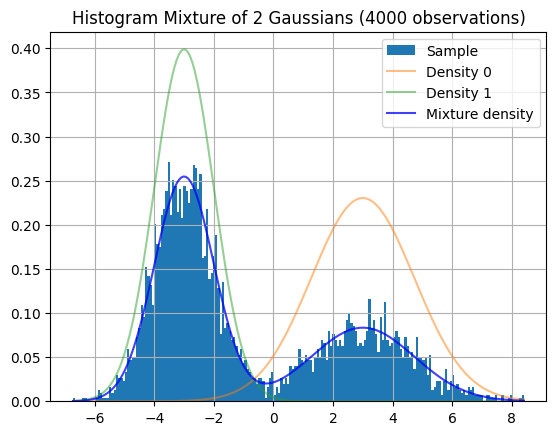

In [75]:
## Visualilsation du mélange
fig, ax = plt.subplots()
count, bins, ignored = plt.hist(Y_obs, 100*NB_GAUSS, density=True, label="Sample")

true_mixture = 0

# affichage des densités marginales et calcul de la mixture
for cl in range(NB_GAUSS):
    plt.plot(bins, like_gauss(bins, true_mu[cl], true_v[cl]), linestyle = 'solid', alpha = 0.5, label=f'Density {cl}')
    true_mixture += like_gauss(bins, true_mu[cl], true_v[cl])* proportions[cl]

plt.plot(bins, true_mixture, linestyle = 'solid', alpha = 0.75, color='b', label="Mixture density")

plt.title(f'Histogram Mixture of {NB_GAUSS} Gaussians ({nb_obs} observations)')
plt.legend()
plt.grid(True)

# Algorithme EM

## Explication Mathématique de EM

**Initialisation :**
Choisir arbitrairement d'un $\theta_0$ représentant nos paramètres de départ pour l'algorithme.

**Étape E :** Calculer $Q(\theta, \theta^{old})=\mathbb{E}_{\theta^{old}}\left[\log p_{\theta}(X,Y)|Y \right]\,$. En considérant la formule développée plus haut, on obtient :

$$
Q(\theta, \theta^{old}) = \sum_{i=1}^r\mathbb{P}_{\theta^{old}}(X_0=i|Y)\log \nu_{i} + \sum_{k=1}^n\sum_{i,j=1}^r  \mathbb{P}_{\theta^{old}}(X_{k-1}=i, X_k=j|Y)  \log Q(i,j) + \sum_{k=0}^n\sum_{i=1}^r  \mathbb{P}_{\theta^{old}}(X_k=i|Y)  \log \phi_{\mu_i, v_i}(Y_k) $$

**Étape M :** Maximiser la valeur $Q(\theta, \theta^{old})$, $ie$ résoudre le système d'équations $\nabla_{\theta} Q(\theta, \theta^{old}) = 0$. Les calculs effectués en TD nous permettent de définir comme nouvelles valeurs pour nos paramètres :


$$
\mu_i^{new} = \frac{\sum_{k=0}^n\mathbb{P}_{\theta^{old}}(X_k=i|Y)Y_k}{\sum_{k=0}^n\mathbb{P}_{\theta^{old}}(X_k=i|Y)}
$$

$$
v_i^{new} = \frac{\sum_{k=0}^n\mathbb{P}_{\theta^{old}}(X_k=i|Y)(Y_k - \mu_i^{new})^2}{\sum_{k=0}^n\mathbb{P}_{\theta^{old}}(X_k=i|Y)}
$$

$$
\nu_i^{new} = \mathbb{P}_{\theta^{old}}(X_0=i|Y)
$$

$$
Q(i,j)^{new} = \frac{\sum_{k=1}^n\mathbb{P}_{\theta^{old}}(X_{k-1}=i,X_k=j|Y)}{\sum_{k=1}^n\mathbb{P}_{\theta^{old}}(X_{k-1}=i|Y)}
$$

À partir d'un $\theta_0$ initial donné, nous allons répeter l'algorithme jusqu'à convergence des estimateurs. À chaque nouveau cycle, $\theta^{old}$ est remplacé par le $\theta^{new}$ calculé. Au niveau de l'implémentation, la boucle EM est ainsi répétée un nombre prédéfini de fois `NB_ITER`, ou jusqu'à convergence des paramètres suivant une certaine distance et une précision de `1e-3`.

## Implémentation de l'algorithme EM

### Initialisation

Dans notre cas, l'initialisation est faite sans aléa. Ainsi, des appels succéssifs de l'algorithme sur le même jeu de données renverra toujours le même résultat. L'initialisation par l'aléatoire de nos paramètres peut nous permettre de chercher un meilleur résultat en relançant simplement l'algorithme, cependant cet aléa peut également fausser la résolution, et demande plus de temps et de capacité de stockage pour garder et comparer les différents estimateurs.

In [8]:
def init(Y, nb_gauss):
    poids = np.ones(nb_gauss) /nb_gauss # on choisit une répartition de départ équiprobable

    moy  = np.mean(Y)       # calcul de la moyenne de l'échantillon
    mu = np.linspace(moy - 1, moy + 1, nb_gauss)    # choix des nb_gauss mus de départ autour de la moyenne

    var = np.square(Y-moy).sum() /len(Y)      # calcul de la variance de l'échantillon
    v = np.ones(nb_gauss) *var/nb_gauss        # on part de la même variance pour toutes les classes

    Q = np.ones((nb_gauss,nb_gauss))/nb_gauss     # on choisit une probabilité de transition équiprobable

    return poids, mu, v, Q, poids

### Algorithme Baum Welch (Étape Expectation)

Dans le cadre d'un apprentissage avec une chaîne de Markov cachée, l'étape Expectation de l'algorithme EM ne suffit plus. En effet, on cherche maintenant, en plus des paramètres du mélange gaussien, à determiner les paramètres de la chaîne de Markov cachée, c'est-à-dire sa matrice de transition $Q$.

Nous utilisons alors un algorithme de type Forward/Backward (ici, l'algorithme de Baum-Welch) pour calculer les estimations des poids à l'étape $i$, ainsi qu'une estimation des valeurs de la matrice de transition.

#### Forward

In [9]:
def forward(Y, nu, mu, v, Q):
    classe = Q.shape[0]      # nombre de classe
    N = len(Y)       # taille de l'échantillon d'observation

    ## initialisation
    alpha = np.zeros((N, classe))
    alpha[0, :] = [nu[cl] * like_gauss(Y[0], mu[cl], v[cl]) for cl in range(classe)]
    alpha[0, :] = alpha[0, :]/alpha[0, :].sum()   #normalisation

    ## boucle
    for k in range(1, N):
        alpha[k, :] = (alpha[k-1, :] @ Q) * like_gauss(Y[k], mu, v)
        alpha[k, :] = alpha[k, :]/alpha[k, :].sum()   #normalisation

    return alpha

#### Backward

In [10]:
def backward(Y, mu, v, Q):
    classe = Q.shape[0]      # nombre de classe
    N = len(Y)       # taille de l'échantillon d'observation

    ## initialisation
    beta = np.zeros((N, classe))
    beta[-1, :] = 1

    ## boucle
    for k in range(2,N+1):
        beta[N-k, :] = Q @ (beta[N-(k-1), :] * like_gauss(Y[N-(k-1)], mu, v))
        beta[N-k, :]  = beta[N-k, :] /beta[N-k, :].sum()    #normalisation

    return beta

#### Boucle

In [11]:
def Baum_Welch(Y, nu, mu, v, Q):
    classe = Q.shape[0]      # nombre de classe
    N = len(Y)       # taille de l'échantillon d'observation

    ## initialisation
    omega_tild = np.zeros((N, classe))
    omega = np.zeros((N-1, classe, classe))

    ## frwrd & bkwrd
    alpha = forward(Y, nu, mu, v, Q)
    beta = backward(Y, mu, v, Q)

    proba_obs = np.sum(alpha*beta, axis=1)

    ## boucle
    for k in range(N-1):
        omega_tild[k, :] = (alpha[k, :]*beta[k, :]) /proba_obs[k]
        for cl in range(classe):
            omega[k, cl, :] = (alpha[k, cl] * Q[cl, :] * like_gauss(Y[k+1], mu, v) * beta[k, :]) /proba_obs[k]

    ## estimation HMM
    new_nu = omega_tild[0, :]
    new_Q = np.sum(omega, axis=0) / np.sum(omega_tild, axis=0)
    new_Q = new_Q/new_Q.sum(1).reshape(classe,1)    #normalisation

    return new_nu, new_Q, omega, omega_tild

### Étape Maximization

In [12]:
def Maximization(Y, omega_tild, poids, mu, v):
    classe = NB_GAUSS      # nombre de classe
    N = len(Y)       # taille de l'échantillon d'observation

    for cl in range(classe):
        # calcul des moyennes de la classe cl
        mu[cl] = np.sum(omega_tild[:,cl]*Y, axis=0) / omega_tild[:,cl].sum()

        # calcul de la variance de la classe cl
        v[cl] = np.sum(omega_tild[:,cl] * np.square(Y-mu[cl]), axis=0) / omega_tild[:,cl].sum()

        # calcul des nouvelles à priori de la classe cl
        poids[cl] = omega_tild[:,cl].sum() / omega_tild.sum()

    return poids, mu, v

### Boucle

In [13]:
def EM(Y, nb_gauss, graph=True, nIterMax=NB_ITER, precision=1e-3):
    ## initialisation
    n = 0
    ecart_mu = 1
    ecart_v = 1
    ecart_Q = 1
    poids, mu, v, Q, nu = init(Y, nb_gauss)
    l_mu = [list(mu)]
    l_sigma = [list(v)]

    ## affichage point de départ
    if graph:
        plot_pdf(Y, mu, v, poids, true_mu, true_v, proportions, n, False)

    while (n < nIterMax and (ecart_mu>precision or ecart_v>precision)):
        # execution successive
        Q_aux = Q.copy()       # utilisation d'une variable auxiliaire pour calcul de l'écart
        nu, Q, omega, omega_tild = Baum_Welch(Y, nu, mu, v, Q)

        mu_aux = mu.copy()       # utilisation d'une variable auxiliaire pour calcul de l'écart
        v_aux = v.copy()       # utilisation d'une variable auxiliaire pour calcul de l'écart
        poids, mu, v = Maximization(Y, omega_tild, poids, mu, v)

        ecart_mu = np.abs(mu - mu_aux).sum()      # calcul de l'écart
        ecart_v = np.abs(v - v_aux).sum()      # calcul de l'écart
        ecart_Q = np.linalg.norm(Q - Q_aux)      # calcul de l'écart
        l_mu.append(list(mu))
        l_sigma.append(list(v))

        n += 1
        if (n%10 == 0) and (graph):
            plot_pdf(Y, mu, v, poids, true_mu, true_v, proportions, n, False)

    print("\nNb d'itération : ", n)
    print("Écart moyennes (somme des différences absolues) : ", ecart_mu)
    print("Écart variances (somme des différences absolues) : ", ecart_v)
    print("Écart Q (norme) : ", ecart_Q)

    return poids, mu, v, nu, Q, n, l_mu, l_sigma

# Mise en oeuvre

#### outil plot

*code permettant un bel affichage des estimations marginales et de la mixture*

In [14]:
## Visualiation
def plot_pdf(Y, mu, sigma, nu, true_mu, true_v, proportions, it, grand=True):
    if (grand):
        plt.figure(figsize=(15,5))
    else:
        plt.figure(figsize=(9,4))

    plt.subplot(1,2,1)
    plt.xlabel("$x$")
    plt.ylabel("probability density")

    mixture = 0
    true_mixture = 0
    count, bins, ignored = plt.hist(Y, 100*NB_GAUSS, density=True, alpha = 0.9)

    for cl in range(NB_GAUSS):
        plt.plot(bins, like_gauss(bins, true_mu[cl], true_v[cl]), linestyle = 'solid', alpha = 0.5)
        true_mixture += like_gauss(bins, true_mu[cl], true_v[cl])* proportions[cl]

    for cl in range(len(mu)):
        plt.plot(bins, like_gauss(bins, mu[cl], sigma[cl]), linestyle = 'dashed', alpha = 0.5, label="Estimated density")
        mixture += like_gauss(bins, mu[cl], sigma[cl])*nu[cl]

    plt.tick_params(labelright=True)
    plt.legend()
    plt.title(f'Densités marginales (iteration {it})')
    plt.grid('True')


    plt.subplot(1,2,2)
    plt.xlabel("$x$")
    plt.ylabel("probability density")

    count, bins, ignored = plt.hist(Y, 100*NB_GAUSS, density=True, alpha = 0.9)
    plt.plot(bins, true_mixture, linestyle = 'solid', alpha = 0.5, color='b', label="True mixture density")
    plt.plot(bins, mixture, linestyle = 'dashed', alpha = 0.6, color='cyan', label="Estimated mixture density")

    plt.tick_params(labelright=True)
    plt.grid('True')
    plt.legend()
    plt.title(f'Densité de la mixture (iteration {it})')
    plt.tight_layout()


## Apprentissage


Nb d'itération :  13
Écart moyennes (somme des différences absolues) :  0.00015438648012189304
Écart variances (somme des différences absolues) :  0.0004244654010465698
Écart Q (norme) :  0.0019231409223814582


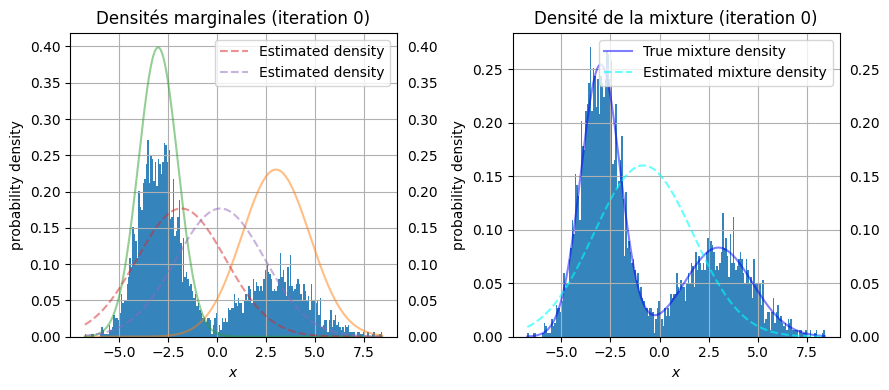

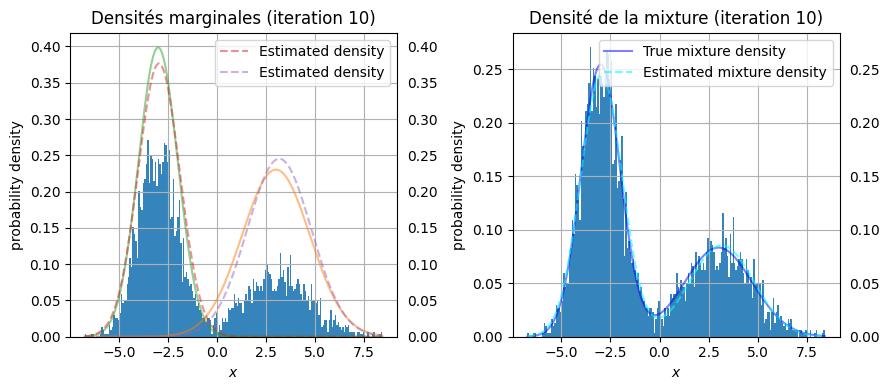

In [76]:
## Execution
poids, mu, v, nu, Q, n, list_mu, list_sigma = EM(Y_obs, NB_GAUSS, graph=True)

## Visualisation des résultats


*** Rappel des vraies valeurs de la HMM ***
Position initiale : [0.3 0.7]
Matrice de transition :
 [[0.5 0.5]
 [0.3 0.7]]
Poids :
 [0.362 0.638]
Moyenne :
 [ 3 -3]
Variance :
 [3 1]

Estimations Finales : 
Position initiale (pas utile sur un échantillon non segmenté) :  [1.00000000e+00 1.64547531e-29]
Matrice de transition :
 [[0.89399535 0.10600465]
 [0.76801538 0.23198462]]
Poids :
 [0.65166915 0.34833085]
Moyennes :
 [-2.95903553  3.17397675]
Variances :
 [1.12529982 2.63930781]


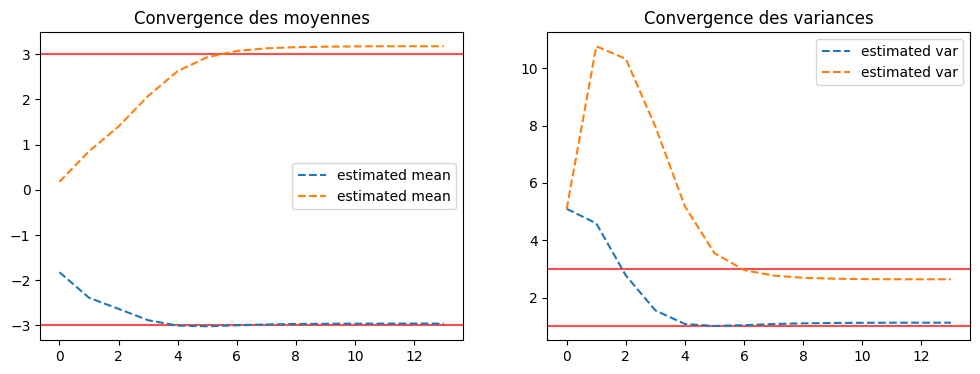

In [80]:
print("\n*** Rappel des vraies valeurs de la HMM ***")
print("Position initiale :", nu_HMM)
print("Matrice de transition :\n", Q_HMM)
print("Poids :\n", proportions)
print("Moyenne :\n", true_mu)
print("Variance :\n", true_v)

print("\nEstimations Finales : ")
print("Position initiale (pas utile sur un échantillon non segmenté) : ", nu)
print("Matrice de transition :\n", Q)
print("Poids :\n", poids)
print("Moyennes :\n", mu)
print("Variances :\n", v)


plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for mu_ in true_mu:
    plt.axhline(mu_, color='r', alpha=0.7, linestyle = 'solid')
plt.plot(range(n+1), list_mu, label="estimated mean", linestyle = 'dashed')
plt.title("Convergence des moyennes")
plt.legend()

plt.subplot(1,2,2)
for sig_ in true_v:
    plt.axhline(sig_, color='r', alpha=0.7, linestyle = 'solid')
plt.plot(range(n+1), list_sigma, label="estimated var", linestyle = 'dashed')
plt.title("Convergence des variances")
plt.legend()

plt.show()

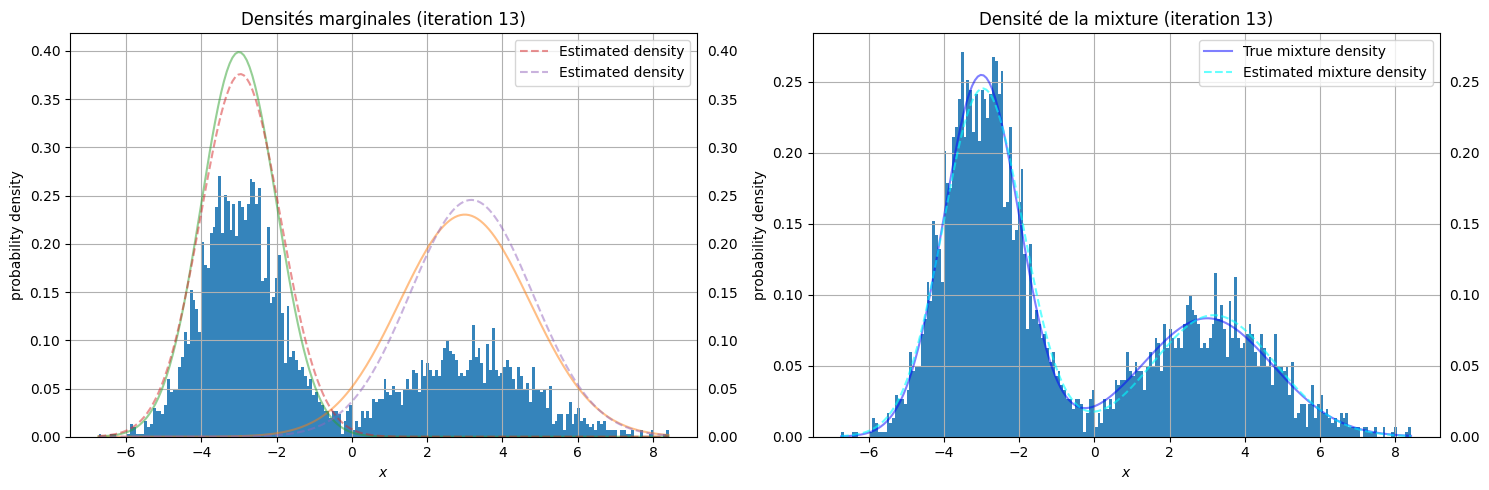

In [78]:
## ZOOMÉ
plot_pdf(Y_obs, mu, v, poids, true_mu, true_v, proportions, n)

### Commentaires

L'estimation de la mixture ainsi que des lois marginales est assez bonne et se rapproche des lois originales. De plus, la convergence des estimateurs des moyennes et des variances est relativement rapide (ici, moins de 10 itérations pour s'approcher, moins de 15 pour se stabiliser avec une précision de $10^{-3}$). De même, l'estimation des poids est proche des valeurs empiriques calculées lors de la simulation.

Cependant, l'aglorithme est plutôt mauvais pour estimer les paramètres de la chaîne de Markov. D'une part, comme nous ne séparons pas nos données d'entrainement, l'algorithme tel qu'écrit ici ne permet pas d'estimer les probabilités initiales $\nu$. En effet comme nous ne considérons qu'une seule trajectoire, il n'est pas pertinant de chercher à estimer la répartition initiale sur les états de la chaîne de Markov. Nous pourrions pour palier à ça considérer plusieurs marches plus courtes, et regarder une moyenne empirique des points de départ.

De plus, l'estimateur pour la matrice de transition $Q$ n'est pas non plus convaincant. Une explication possible peut être que, bien que l'algorithme estime correctement les paramètres des lois, il ne les cherche et ne les classe pas forcément dans le même ordre que nos déclarations, ce qui peut être plus difficile à relire. Ce n'est cependant pas le cas ici.

## Simulation selon les paramètres estimés

Nous allons maintenant tester l'estimation de notre modèle en simulant un tirage selon les paramètres de ce dernier.

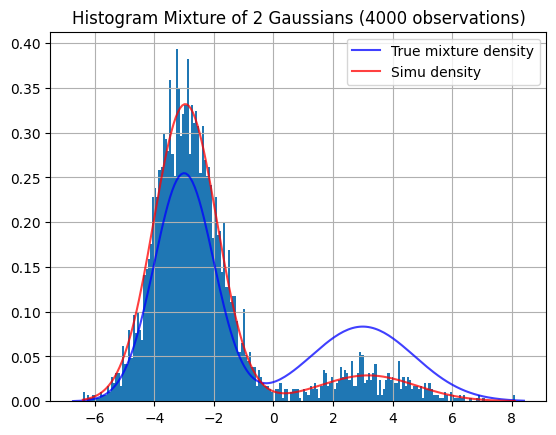

In [79]:
## Observations suivant marche aléatoire
nb_obs = 2000*NB_GAUSS

X_state_test = np.array([], dtype=int)
Y_obs_test = np.array([])

# initialisation du point de départ
X_state_test = np.append(X_state_test, np.random.choice(NB_GAUSS, p=nu))
Y_obs_test = np.append(Y_obs_test, np.random.normal(mu[X_state_test[-1]], np.sqrt(v[X_state_test[-1]])) )

for _ in range(1, nb_obs):
    # passage d'un état à l'autre
    X_state_test = np.append(X_state_test, np.random.choice(NB_GAUSS, p=Q[X_state_test[-1]]))
    # observation par le nouvel état
    Y_obs_test = np.append(Y_obs_test, np.random.normal(mu[X_state_test[-1]], np.sqrt(v[X_state_test[-1]])) )

# porportion empirique de chaque état
proportions_test = np.bincount(X_state_test)/nb_obs

## Visualilsation
fig, ax = plt.subplots()
plt.plot(bins, true_mixture, linestyle = 'solid', alpha = 0.75, color='b', label="True mixture density")
count, bins, ignored = plt.hist(Y_obs_test, 100*NB_GAUSS, density=True)

test_mixture = 0

for cl in range(NB_GAUSS):
    test_mixture += like_gauss(bins, mu[cl], v[cl])* proportions_test[cl]

plt.plot(bins, test_mixture, linestyle = 'solid', alpha = 0.75, color='r', label="Simu density")

plt.title(f'Histogram Mixture of {NB_GAUSS} Gaussians ({nb_obs} observations)')
plt.legend()
plt.grid(True)

### Commentaires

Du fait de la mauvaise estimation de la matrice de transition, une simulation selon le modèle proposé par l'algorithme ne suit pas parfaitement la vraie densité du mélange des gaussiennes. Bien que les paramètres des marginales soient bien positionnés, les transitions ne suivent pas la bonne loi et ainsi la génération des gaussiennes est clairement faussée.

## Modèle généré aléatoirement (1)

Maintenant, nous allons tester notre algorithme sur une chaîne de Markov et des lois gaussiennes dont les paramètres ont été déterminés aléatoirement. Nous choississons tout de même arbitrairement des bornes pour ces valeurs, déterminées par nos hyper-paramètres, pour mieux visualiser les résultats. Ces paramètres peuvent être modifiés à l'exécution.

In [31]:
## Hyper-paramètres
NB_GAUSS = 2

MOY_MIN = -5*NB_GAUSS
MOY_MAX = 5*NB_GAUSS

VAR_MAX = 2*NB_GAUSS

In [32]:
## Markov Cachée (générée aléatoirement)
# vecteur de position initiale
nu_HMM_alea = np.random.uniform(size=NB_GAUSS)
nu_HMM_alea = nu_HMM_alea/nu_HMM_alea.sum()    # normalisation
print("nu_HMM_alea :\n", nu_HMM_alea)

# matrice de transition
Q_HMM_alea = np.random.uniform(size=(NB_GAUSS,NB_GAUSS))
Q_HMM_alea = Q_HMM_alea/Q_HMM_alea.sum(1).reshape(NB_GAUSS,1)    # normalisation
print("Q_HMM_alea :\n", Q_HMM_alea)

# matrice d'observation
true_mu_alea = np.random.uniform(MOY_MIN, MOY_MAX, size=NB_GAUSS)
true_v_alea = np.random.uniform(VAR_MAX, size=NB_GAUSS)
print("true_mu_alea :\n", true_mu_alea)
print("true_v_alea :\n", true_v_alea)

nu_HMM_alea :
 [0.29043851 0.70956149]
Q_HMM_alea :
 [[0.36995351 0.63004649]
 [0.40358874 0.59641126]]
true_mu_alea :
 [ 6.20279697 -3.3742025 ]
true_v_alea :
 [2.07830473 3.88276965]


In [33]:
## Observations suivant marche aléatoire
nb_obs = 2000*NB_GAUSS

X_state_alea = np.array([], dtype=int)
Y_obs_alea = np.array([])

# initialisation du point de départ
X_state_alea = np.append(X_state_alea, np.random.choice(NB_GAUSS, p=nu_HMM_alea))
Y_obs_alea = np.append(Y_obs_alea, np.random.normal(true_mu_alea[X_state_alea[-1]], np.sqrt(true_v_alea[X_state_alea[-1]])) )

for _ in range(1, nb_obs):
    # passage d'un état à l'autre
    X_state_alea = np.append(X_state_alea, np.random.choice(NB_GAUSS, p=Q_HMM_alea[X_state_alea[-1]]))
    # observation par le nouvel état
    Y_obs_alea = np.append(Y_obs_alea, np.random.normal(true_mu_alea[X_state_alea[-1]], np.sqrt(true_v_alea[X_state_alea[-1]])) )

# porportion empirique de chaque état
proportions_alea = np.bincount(X_state_alea)/nb_obs
print(proportions_alea)

[0.388 0.612]


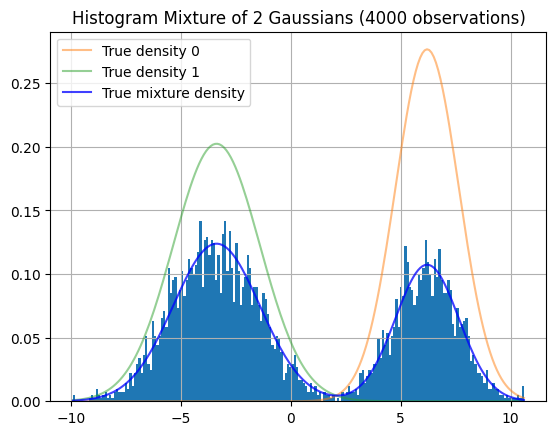

In [34]:
## Visualilsation
fig, ax = plt.subplots()
count, bins, ignored = plt.hist(Y_obs_alea, 100*NB_GAUSS, density=True)

true_mixture_alea = 0

for cl in range(NB_GAUSS):
    plt.plot(bins, like_gauss(bins, true_mu_alea[cl], true_v_alea[cl]), linestyle = 'solid', alpha = 0.5, label=f'True density {cl}')
    true_mixture_alea += like_gauss(bins, true_mu_alea[cl], true_v_alea[cl])* proportions_alea[cl]

plt.plot(bins, true_mixture_alea, linestyle = 'solid', alpha = 0.75, color='b', label="True mixture density")

plt.title(f'Histogram Mixture of {NB_GAUSS} Gaussians ({nb_obs} observations)')
plt.legend()
plt.grid(True)

In [35]:
## Execution
poids_alea, mu_alea, v_alea, nu_alea, Q_alea, n, list_mu_alea, list_sigma_alea = EM(Y_obs_alea, NB_GAUSS, graph=False, nIterMax=200)


Nb d'itération :  200
Écart moyennes (somme des différences absolues) :  1.351377232298244
Écart variances (somme des différences absolues) :  5.85364893275046
Écart Q (norme) :  0.06865449387891291



*** Rappel des vraies valeurs de la HMM ***
Position initiale : [0.29043851 0.70956149]
Matrice de transition :
 [[0.36995351 0.63004649]
 [0.40358874 0.59641126]]
Poids :
 [0.388 0.612]
Moyenne :
 [ 6.20279697 -3.3742025 ]
Variance :
 [2.07830473 3.88276965]

Estimations Finales : 
Position initiale (pas utile sur un échantillon non segmenté) :  [1. 0.]
Matrice de transition :
 [[0.06955893 0.93044107]
 [0.08848823 0.91151177]]
Poids :
 [0.47243276 0.52756724]
Moyennes :
 [-4.11253858  4.22439028]
Variances :
 [ 2.53744847 12.4313893 ]


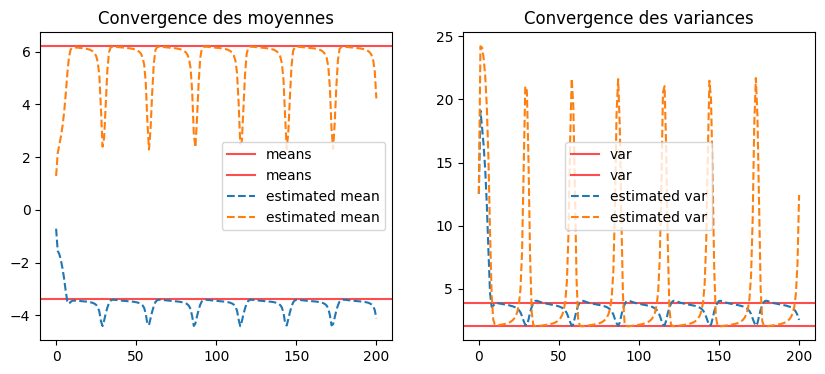

In [36]:
print("\n*** Rappel des vraies valeurs de la HMM ***")
print("Position initiale :", nu_HMM_alea)
print("Matrice de transition :\n", Q_HMM_alea)
print("Poids :\n", proportions_alea)
print("Moyenne :\n", true_mu_alea)
print("Variance :\n", true_v_alea)

print("\nEstimations Finales : ")
print("Position initiale (pas utile sur un échantillon non segmenté) : ", nu_alea)
print("Matrice de transition :\n", Q_alea)
print("Poids :\n", poids_alea)
print("Moyennes :\n", mu_alea)
print("Variances :\n", v_alea)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
for mu_ in true_mu_alea:
    plt.axhline(mu_, color='r', alpha=0.7, label="means", linestyle = 'solid')
plt.plot(range(n+1), list_mu_alea, label="estimated mean", linestyle = 'dashed')
plt.title("Convergence des moyennes")
plt.legend()

plt.subplot(1,2,2)
for sig_ in true_v_alea:
    plt.axhline(sig_, color='r', alpha=0.7, label="var", linestyle = 'solid')
plt.plot(range(n+1), list_sigma_alea, label="estimated var", linestyle = 'dashed')
plt.title("Convergence des variances")
plt.legend()
plt.show()

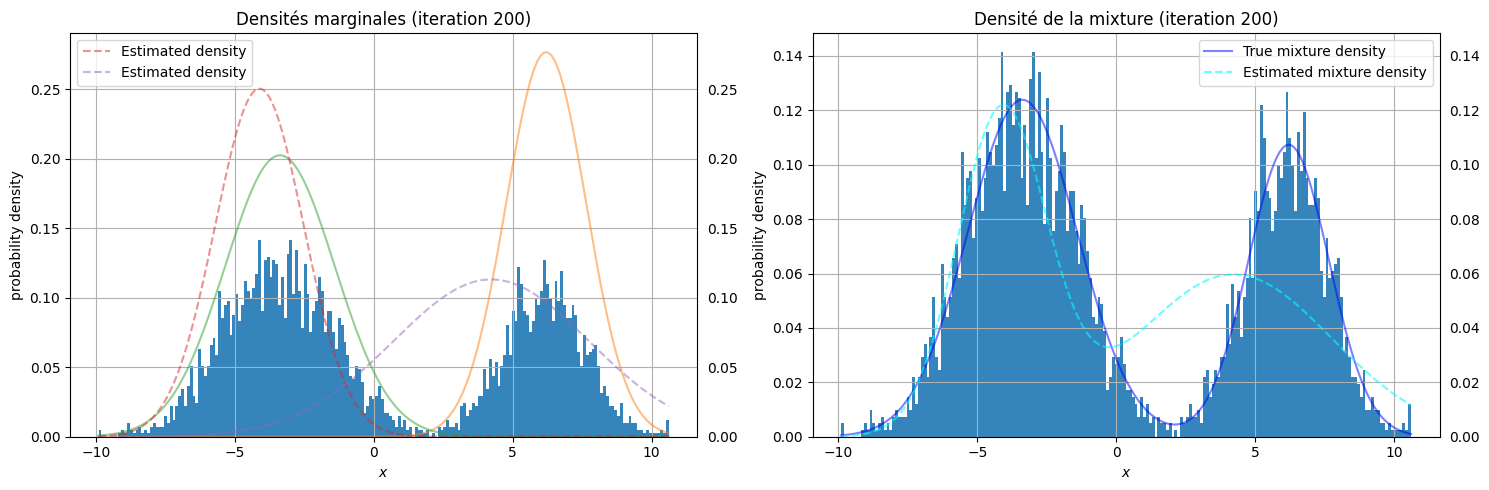

In [37]:
## ZOOMÉ
plot_pdf(Y_obs_alea, mu_alea, v_alea, poids_alea, true_mu_alea, true_v_alea, proportions_alea, n)

## Modèle généré aléatoirement (2)

In [38]:
## Hyper-paramètres
NB_GAUSS = 3

MOY_MIN = -5*NB_GAUSS
MOY_MAX = 5*NB_GAUSS

VAR_MAX = 2*NB_GAUSS

In [53]:
## Markov Cachée (générée aléatoirement)
# vecteur de position initiale
nu_HMM_alea = np.random.uniform(size=NB_GAUSS)
nu_HMM_alea = nu_HMM_alea/nu_HMM_alea.sum()    # normalisation
print("nu_HMM_alea :\n", nu_HMM_alea)

# matrice de transition
Q_HMM_alea = np.random.uniform(size=(NB_GAUSS,NB_GAUSS))
Q_HMM_alea = Q_HMM_alea/Q_HMM_alea.sum(1).reshape(NB_GAUSS,1)    # normalisation
print("Q_HMM_alea :\n", Q_HMM_alea)

# matrice d'observation
true_mu_alea = np.random.uniform(MOY_MIN, MOY_MAX, size=NB_GAUSS)
true_v_alea = np.random.uniform(VAR_MAX, size=NB_GAUSS)
print("true_mu_alea :\n", true_mu_alea)
print("true_v_alea :\n", true_v_alea)

nu_HMM_alea :
 [0.18667136 0.80177981 0.01154882]
Q_HMM_alea :
 [[0.51315557 0.14559381 0.34125062]
 [0.16508768 0.49451645 0.34039587]
 [0.42919533 0.09248215 0.47832253]]
true_mu_alea :
 [ 10.44472562  -5.30421452 -14.79348874]
true_v_alea :
 [4.57557696 1.1503712  1.65046809]


In [54]:
## Observations suivant marche aléatoire
nb_obs = 2000*NB_GAUSS

X_state_alea = np.array([], dtype=int)
Y_obs_alea = np.array([])

# initialisation du point de départ
X_state_alea = np.append(X_state_alea, np.random.choice(NB_GAUSS, p=nu_HMM_alea))
Y_obs_alea = np.append(Y_obs_alea, np.random.normal(true_mu_alea[X_state_alea[-1]], np.sqrt(true_v_alea[X_state_alea[-1]])) )

for _ in range(1, nb_obs):
    # passage d'un état à l'autre
    X_state_alea = np.append(X_state_alea, np.random.choice(NB_GAUSS, p=Q_HMM_alea[X_state_alea[-1]]))
    # observation par le nouvel état
    Y_obs_alea = np.append(Y_obs_alea, np.random.normal(true_mu_alea[X_state_alea[-1]], np.sqrt(true_v_alea[X_state_alea[-1]])) )

# porportion empirique de chaque état
proportions_alea = np.bincount(X_state_alea)/nb_obs
print(proportions_alea)

[0.40216667 0.19416667 0.40366667]


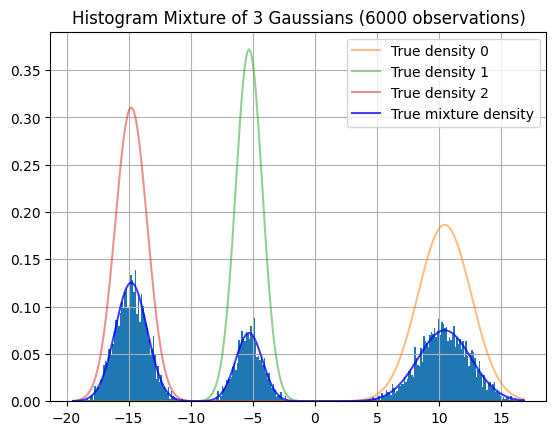

In [55]:
## Visualilsation
fig, ax = plt.subplots()
count, bins, ignored = plt.hist(Y_obs_alea, 100*NB_GAUSS, density=True)

true_mixture_alea = 0

for cl in range(NB_GAUSS):
    plt.plot(bins, like_gauss(bins, true_mu_alea[cl], true_v_alea[cl]), linestyle = 'solid', alpha = 0.5, label=f'True density {cl}')
    true_mixture_alea += like_gauss(bins, true_mu_alea[cl], true_v_alea[cl])* proportions_alea[cl]

plt.plot(bins, true_mixture_alea, linestyle = 'solid', alpha = 0.75, color='b', label="True mixture density")

plt.title(f'Histogram Mixture of {NB_GAUSS} Gaussians ({nb_obs} observations)')
plt.legend()
plt.grid(True)

In [56]:
## Execution
poids_alea, mu_alea, v_alea, nu_alea, Q_alea, n, list_mu_alea, list_sigma_alea = EM(Y_obs_alea, NB_GAUSS, graph=False)


Nb d'itération :  22
Écart moyennes (somme des différences absolues) :  4.274319334029997e-07
Écart variances (somme des différences absolues) :  2.1054509553586342e-06
Écart Q (norme) :  0.1452422144655245



*** Rappel des vraies valeurs de la HMM ***
Position initiale : [0.18667136 0.80177981 0.01154882]
Matrice de transition :
 [[0.51315557 0.14559381 0.34125062]
 [0.16508768 0.49451645 0.34039587]
 [0.42919533 0.09248215 0.47832253]]
Poids :
 [0.40216667 0.19416667 0.40366667]
Moyenne :
 [ 10.44472562  -5.30421452 -14.79348874]
Variance :
 [4.57557696 1.1503712  1.65046809]

Estimations Finales : 
Position initiale (pas utile sur un échantillon non segmenté) :  [0.00000000e+00 1.32957333e-99 1.00000000e+00]
Matrice de transition :
 [[0.50186134 0.40094722 0.09719144]
 [0.1422682  0.84330036 0.01443144]
 [0.31576639 0.58034008 0.10389353]]
Poids :
 [0.40356721 0.19419909 0.40223371]
Moyennes :
 [-14.79307666  -5.28656456  10.41467371]
Variances :
 [1.70766766 1.13453622 4.48011881]


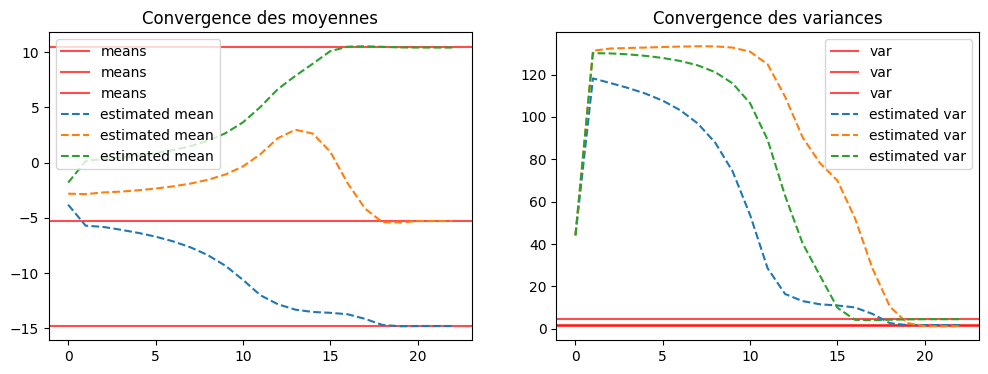

In [58]:
print("\n*** Rappel des vraies valeurs de la HMM ***")
print("Position initiale :", nu_HMM_alea)
print("Matrice de transition :\n", Q_HMM_alea)
print("Poids :\n", proportions_alea)
print("Moyenne :\n", true_mu_alea)
print("Variance :\n", true_v_alea)

print("\nEstimations Finales : ")
print("Position initiale (pas utile sur un échantillon non segmenté) : ", nu_alea)
print("Matrice de transition :\n", Q_alea)
print("Poids :\n", poids_alea)
print("Moyennes :\n", mu_alea)
print("Variances :\n", v_alea)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for mu_ in true_mu_alea:
    plt.axhline(mu_, color='r', alpha=0.7, label="means", linestyle = 'solid')
plt.plot(range(n+1), list_mu_alea, label="estimated mean", linestyle = 'dashed')
plt.title("Convergence des moyennes")
plt.legend()

plt.subplot(1,2,2)
for sig_ in true_v_alea:
    plt.axhline(sig_, color='r', alpha=0.7, label="var", linestyle = 'solid')
plt.plot(range(n+1), list_sigma_alea, label="estimated var", linestyle = 'dashed')
plt.title("Convergence des variances")
plt.legend()
plt.show()

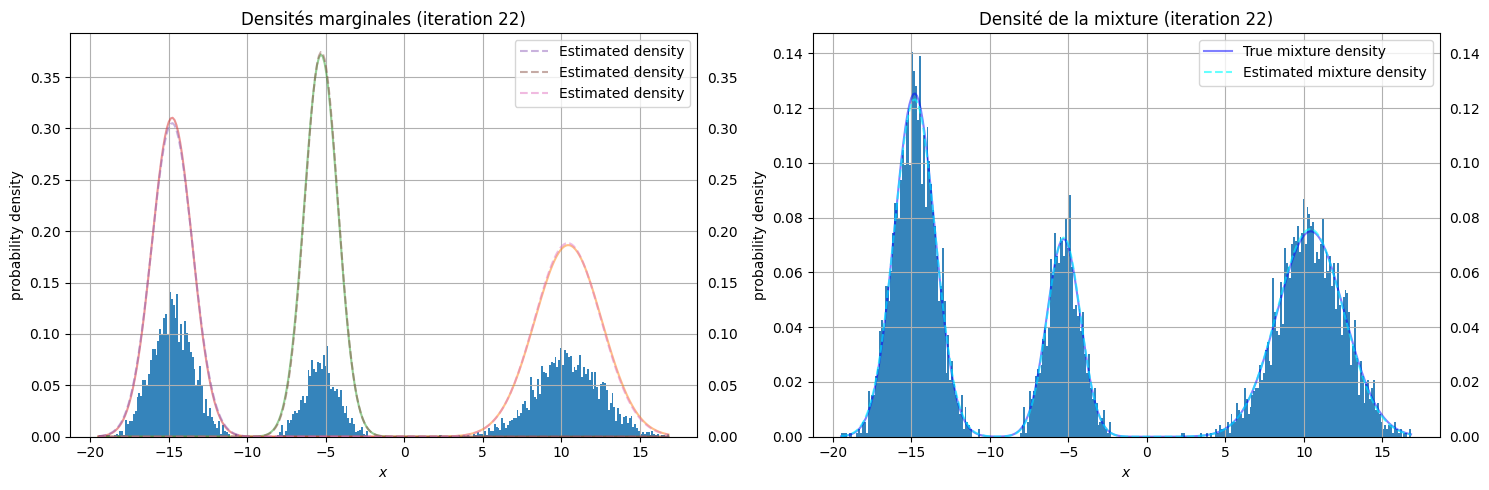

In [59]:
## ZOOMÉ
plot_pdf(Y_obs_alea, mu_alea, v_alea, poids_alea, true_mu_alea, true_v_alea, proportions_alea, n)

# Commentaires


De manière générale, l'algorithme fourni un assez bon estimateur de la mixture des gaussiennes. Nous pouvons voir en effectuant plusieurs applications que la courbe estimée se rapproche souvent de la densité réelle. Cependant, en faisant tourner notre algorithme sur différentes modélisations de paramètres aléatoires, nous constatons malgré une bonne estimation du mélange global, que les gaussiennes marginales peuvent être mal voire très mal estimées. Notamment, lorsque les lois individuelles sont trop resserrées (ie si les moyennes sont trop proches ou si les lois ont un chevauchement trop important), les paramètres des lois individuelles ne seront pas correctement estimés. Au contraire si les lois sont suffisemment espacées, l'algorithme fourni le plus souvent un estimation correcte, à la fois de la mixture gaussienne et également des lois individuelles.

Globalement, nous pouvons dire que la combinaison des paramètres des gaussiennes avec les estimations des poids de chacune de ces lois permet tout de même d'obtenir une densité proche de la densité du vrai mélange. L'algorithme EM implémenté peut alors sembler efficace pour déterminer de manière globale notre combinaisons de paramètres, en dépit des gaussiennes individuelles.

Il y a cependant certaines générations aléatoires de modèle qui ne permette pas une bonne convergence de l'algorithme. En effet, comme il est possible de voir sur la première modélisation aléatoire, bien que les estimateurs se rapprochent des bons paramètres, ils n'y restent pas suffisemment longtemps pour permettre un arrêt de l'algorithme. Celui-ci tourne donc en boucle sans trouver d'estimateurs qui lui semblent convenable.

Pour tenter d'obtenir de meilleures estimations sur des modèles plus singuliers, nous pouvons notamment tenter de modifier les paramètres d'initialisation de notre algorithme, par exemple en choississant autrement la variance de départ, ou en les déterminant de façon aléatoire.

Un soucis a d'ailleurs été rencontré lors de différents tests sur des mélanges d'un nombre trop élevé de gaussiennes : si les moyennes initiales sont trop proches les unes des autres, il y a un risque de fausser le calcul de l'écart en se déplaçant trop lentement, et donc de sortir de la boucle EM avant une réelle convergence des estimateurs.